# HCC case

In [1]:
from platform import python_version
print(python_version())

3.7.3


In [2]:
import numpy as np
import pandas as pd
import feyn

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from functions import crossvalidation_as_framework, random_forest_benchmark, lasso_benchmark, gradient_boosting_benchmark, elasticnet_benchmark
from functions import modsum, model_features_chart


In [3]:
feyn.__version__

'2.1.2'

In [4]:
# Load the data
data = pd.read_csv("../data/cancer_hcc.csv")

In [5]:
data.shape

(91, 1713)

In [6]:
# Define the semantic types
stypes = {}
for f in data.columns:
    if data[f].dtype =='object':
        stypes[f] = 'c'
        
# Set random seed for reproducibility
random_seed = 42

# Define the target variable
target = "target"

In [7]:
### get the test data
random_seed = 42
train_val, test = train_test_split(data, test_size=0.2, stratify=data[target], random_state=random_seed)

## Set multifigure filename

In [8]:
filename = '../figures/'

## In depth modelling 

In [9]:
projectname = 'hcc_mctaseq_epigenomics_'

In [10]:
pathname = '../figures/'

In [11]:
### Get the test data
random_seed = 42
train_val, test = train_test_split(data, test_size=0.2, stratify=data[target], random_state=random_seed)

In [12]:
epochs = 50
criterion = 'bic'
max_complexity = 5
random_seed = 15
sw = np.where(train_val[target] == 1, np.sum(train_val[target] == 0)/sum(train_val[target]), 1)

In [13]:
ql = feyn.connect_qlattice(server="https://qlattice.stage.abzu.ai") # Connecting
ql.reset(random_seed) # Resetting
models_single = ql.auto_run(data = train_val,
                         output_name = target,
                         kind = "classification",
                         stypes = stypes,
                         n_epochs = epochs,
                         criterion=criterion,
                         max_complexity = max_complexity,
                         sample_weights=sw)

In [14]:
def simple_str(m):
    return "logreg(" +  ''.join(list(map(lambda x:x[0:8], str(m)[7:-1].replace("*"," * ").split())))+")"

df_summary = modsum(models_single, train_val, test)[['N. Features', 'Functional form', 'BIC', 'Loss', 'AUC Train']]
df_summary['Functional form'] = df_summary['Functional form'].apply(simple_str)
df_summary.to_csv(filename+projectname+"summary.csv")
df_summary

,N. Features,Functional form,BIC,Loss,AUC Train
0,3,logreg(chr16676+chr17594+chr68783),11.67,0.021642,1.0
1,3,logreg(chr10131*chr17594+chrX3754),13.56,0.005101,1.0
2,3,logreg(chr16896+chr17594+chr61585),13.62,0.035156,1.0
3,3,logreg(chr10131*chr17594+chr11069),14.19,0.009462,1.0
4,3,logreg(chr11177+chr17594+chr51881),14.68,0.042525,1.0
5,2,logreg(chr17594+chr39987),14.72,0.072524,1.0
6,3,logreg(chr10131+chr17594+chr72324),14.75,0.043011,1.0
7,2,logreg(chr17594+chr68783),17.81,0.094013,0.99
8,3,logreg(chr17594+chr31195+chr39987),19.82,0.078207,1.0
9,3,logreg(chr17594+chr19495+chr61585),19.88,0.078681,1.0


In [15]:
print(df_summary.to_latex())

\begin{tabular}{lrllrl}
\toprule
{} &  N. Features &                     Functional form &    BIC &      Loss & AUC Train \\
\midrule
0 &            3 &  logreg(chr16676+chr17594+chr68783) &  11.67 &  0.021642 &       1.0 \\
1 &            3 &  logreg(chr10131*chr17594+chrX3754) &  13.56 &  0.005101 &       1.0 \\
2 &            3 &  logreg(chr16896+chr17594+chr61585) &  13.62 &  0.035156 &       1.0 \\
3 &            3 &  logreg(chr10131*chr17594+chr11069) &  14.19 &  0.009462 &       1.0 \\
4 &            3 &  logreg(chr11177+chr17594+chr51881) &  14.68 &  0.042525 &       1.0 \\
5 &            2 &           logreg(chr17594+chr39987) &  14.72 &  0.072524 &       1.0 \\
6 &            3 &  logreg(chr10131+chr17594+chr72324) &  14.75 &  0.043011 &       1.0 \\
7 &            2 &           logreg(chr17594+chr68783) &  17.81 &  0.094013 &      0.99 \\
8 &            3 &  logreg(chr17594+chr31195+chr39987) &  19.82 &  0.078207 &       1.0 \\
9 &            3 &  logreg(chr17594+chr19495+ch

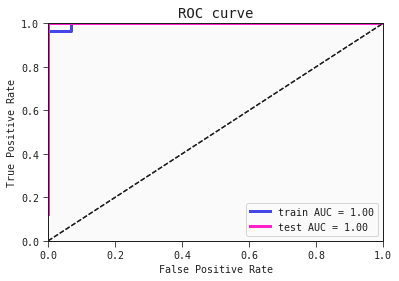

In [16]:
models_single[5].plot_roc_curve(train_val, label='train')
models_single[5].plot_roc_curve(test, label='test', ax=plt.gca())
plt.savefig(pathname+projectname+'roc_auc'+'.pdf', dpi=300, bbox_inches='tight')

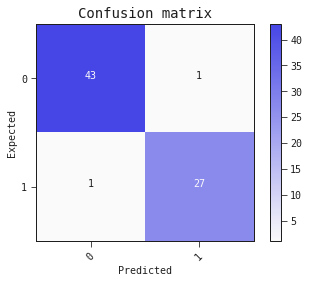

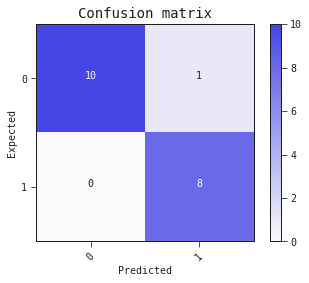

In [17]:
models_single[5].plot_confusion_matrix(train_val, filename=pathname+projectname+'confusion_train'+'.pdf')
models_single[5].plot_confusion_matrix(test, filename=pathname+projectname+'confusion_ttest'+'.pdf')

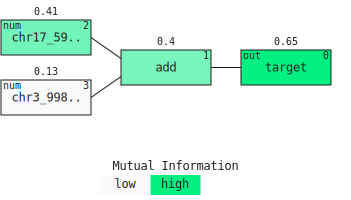

In [18]:
models_single[5].plot_signal(train_val, corr_func='mutual_information', 
                             filename=pathname+projectname+'plot_signal_mi.svg')

In [19]:
sympy_model = models_single[5].sympify(symbolic_lr = True, signif=3)
sympy_model.as_expr()

1/(0.0179*exp(-0.111*chr175947306059483266 + 0.131*chr399878959989619) + 1)

In [20]:
features_data = train_val[models_single[5].features + ["target"]]

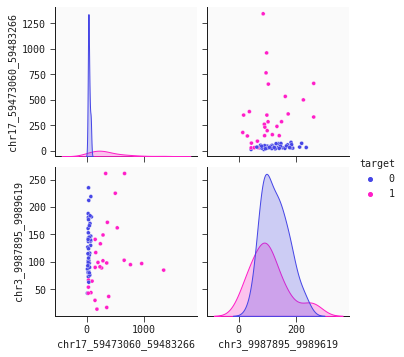

In [21]:
import seaborn as sns
# Pairplot with target coloring
sns.pairplot(features_data, hue = 'target')
plt.savefig(pathname+projectname+'pairplot.pdf')

In [22]:
features_data.columns

Index(['chr17_59473060_59483266', 'chr3_9987895_9989619', 'target'], dtype='object')

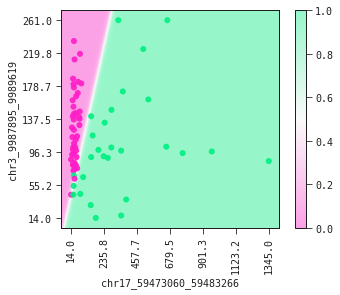

In [23]:
# Plot a 2-dimensional partial plot
models_single[5].plot_response_2d(features_data, filename=pathname+projectname+'plot_response_2d.pdf')

# Cross-validation as a framework

In [24]:
results = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = epochs,
                                     criterion=criterion,
                                     max_complexity = 5)

In [25]:
# average performance of first 10 models
results.roc_auc_val.mean(), results.accuracy_val.mean()

(0.9167857142857144, 0.8688888888888888)

In [26]:
# average performance of first model
results.groupby("fold").first().roc_auc_val.mean(), results.groupby("fold").first().accuracy_val.mean()

(0.922077922077922, 0.8894736842105264)

In [27]:
results.groupby("fold").first().roc_auc_val.std()

0.1101984594056957

In [28]:
results.groupby("fold").first()

,model_structure,aic,bic,roc_auc_train,accuracy_train,roc_auc_val,accuracy_val,pr_auc,f1,query_string
fold,,,,,,,,,,
0,logreg(chr175947306059483266 + chr224901891749...,8.185402,12.738734,1.000000,1.000000,1.000000,0.947368,1.000000,0.727273,"add(add(""chr2_8816314_8817264"", ""chr22_4901891..."
1,logreg(chr175947306059483266 + chr399878959989...,7.746731,12.327650,1.000000,1.000000,1.000000,0.944444,1.000000,0.636364,"add(add(""chr3_9987895_9989619"", ""chr5_18004578..."
2,logreg(chr10131761169131771696 + chr1131573931...,10.531609,15.112528,0.999216,0.986301,1.000000,1.000000,1.000000,0.608696,"add(add(""chr11_315739_316539"", ""chr10_13176116..."
3,logreg(chr126613512066136400 + chr175947306059...,4.112028,6.402488,1.000000,1.000000,0.844156,0.777778,0.763652,0.560000,"add(""chr12_66135120_66136400"", ""chr17_59473060..."
4,logreg(chr224665839746659332*chr59292348792924...,4.012732,8.593651,1.000000,1.000000,0.766234,0.777778,0.773313,0.560000,"multiply(""chr5_92923487_92924497"", ""chr22_4665..."


In [29]:
for m in results.groupby('fold').first().model_structure:
    print(m)

logreg(chr175947306059483266 + chr224901891749019317 + chr288163148817264)
logreg(chr175947306059483266 + chr399878959989619 + chr5180045789180048897)
logreg(chr10131761169131771696 + chr11315739316539 + chr175947306059483266)
logreg(chr126613512066136400 + chr175947306059483266)
logreg(chr224665839746659332*chr59292348792924497)


In [30]:
results10 = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = epochs,
                                     criterion=criterion,
                                     max_complexity = 10)

In [31]:
results10.groupby("fold").first().roc_auc_val.mean()

0.9590909090909092

# Correlation plot for article

In [32]:
models_single[5].features

['chr17_59473060_59483266', 'chr3_9987895_9989619']

In [33]:
# Take a random subset of 100 features
data_wo_target = data.drop('target', axis = 1)
sampled_features = np.unique(list(np.random.choice(data_wo_target.columns, 100, replace=False)) + models_single[5].features)
sample_data = data[sampled_features]

In [34]:
# Prepare for labelling the two model features in the heatmap
label_feature = list()

for x, i in enumerate(sampled_features):
    if i in models_single[5].features:
        label_feature.append(1)
    else: label_feature.append(0)

# Assign colors to chosen features
lut = dict({0: 'w',
           1: 'b'})

# Map colors to correlation data
row_coloring = pd.Series(label_feature, index = sample_data.corr().index).map(lut)

/home/jupyter-miquel.iglesias/.local/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


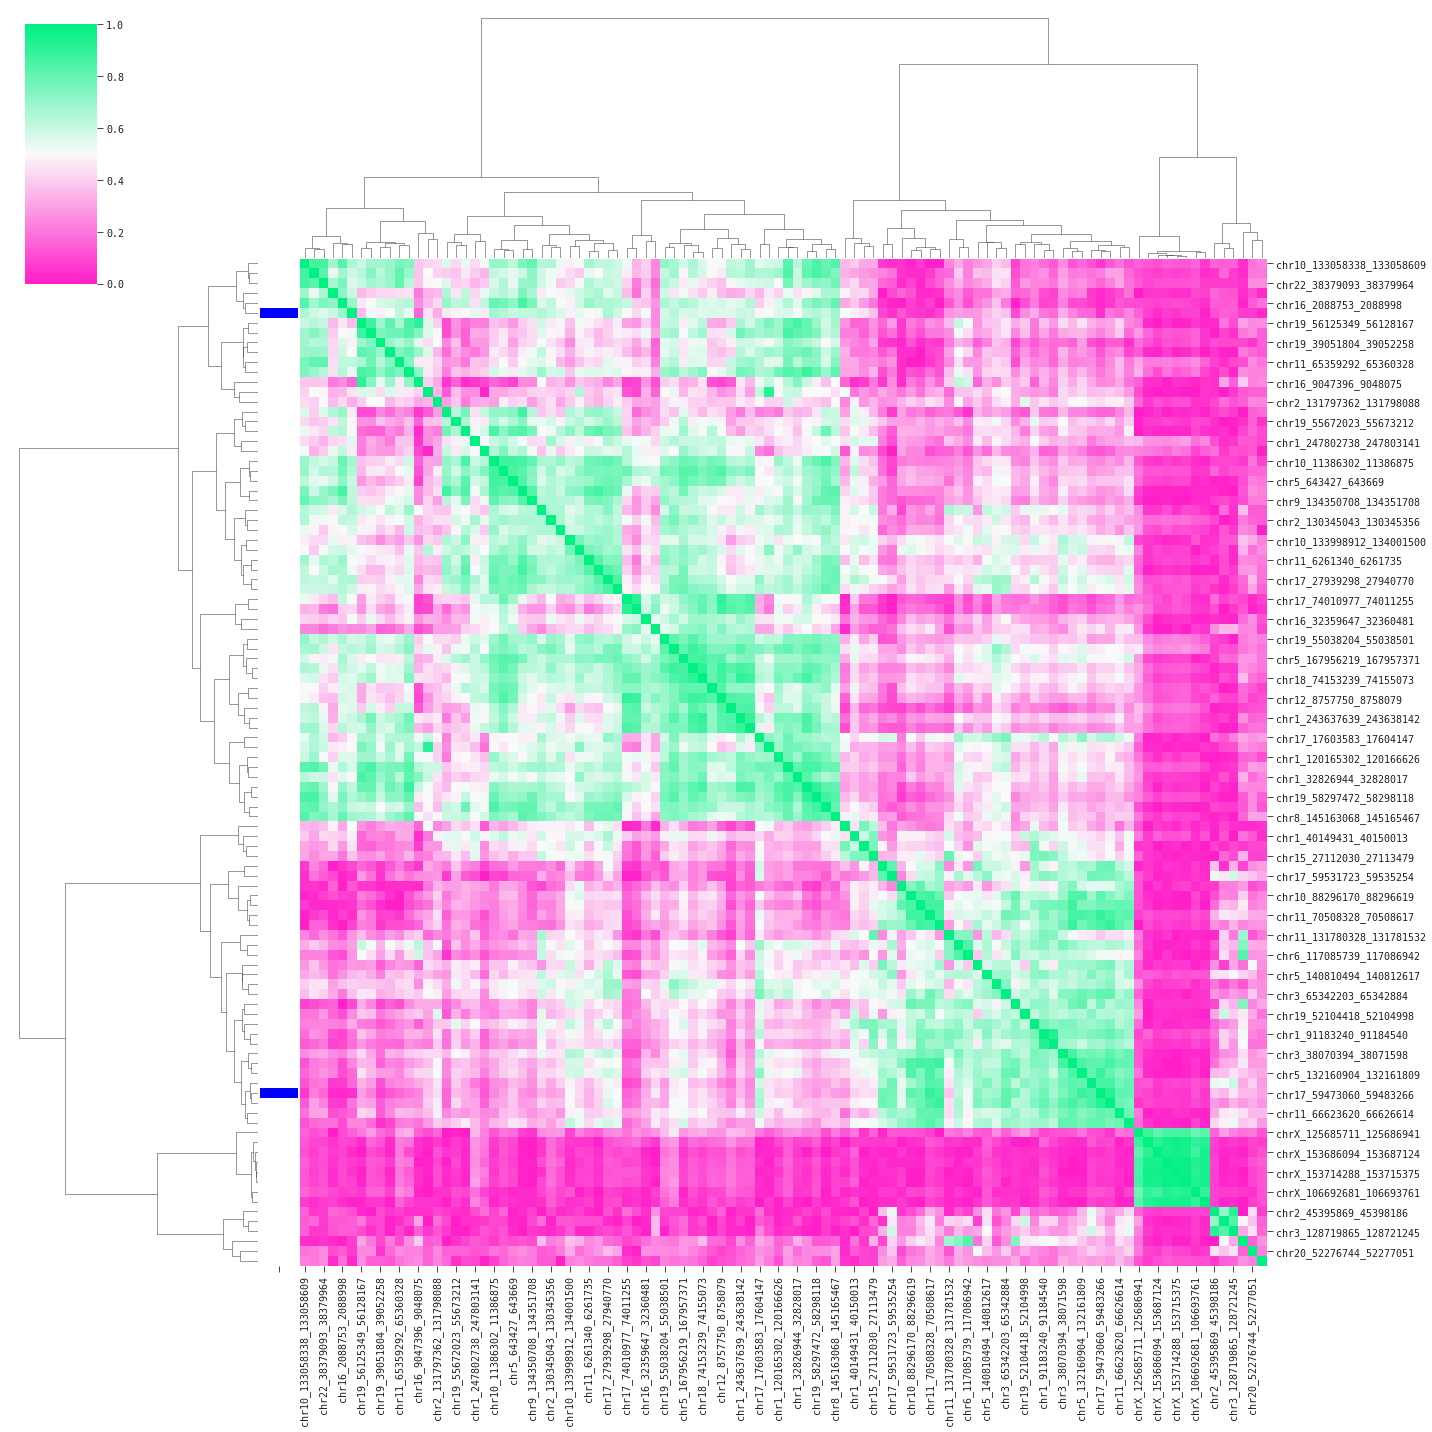

In [35]:
p = sns.clustermap(abs(sample_data.corr()), method="ward", cmap='feyn-diverging', row_colors = row_coloring,
               vmin=0, vmax=1, figsize=(20,20), robust=False)
p.savefig(filename+projectname+"clustermap.pdf")

## Benchmarks

### LASSO

In [36]:
results_lasso = lasso_benchmark(data, target, num_experiments=1, n_jobs=50)

In [37]:
results_lasso

array([0.88636364, 1.        , 0.84415584, 0.94805195, 1.        ])

In [38]:
np.mean(results_lasso)

0.9357142857142857

### Random forest

#### No feature selection

In [39]:
results_rf = random_forest_benchmark(data, target, n_jobs=50)

In [40]:
results_rf

array([0.95454545, 1.        , 0.88311688, 1.        , 1.        ])

In [41]:
results_rf.mean()

0.9675324675324675

#### Feature selection by mutual information

In [42]:
results_rf_mi = random_forest_benchmark(data, target, feat_selection='mi', n_jobs=50)

In [43]:
results_rf_mi

array([0.90909091, 0.98701299, 0.85714286, 0.97402597, 1.        ])

In [44]:
results_rf_mi.mean()

0.9454545454545455

#### Feature selection by f_score

In [45]:
results_rf_f = random_forest_benchmark(data, target, feat_selection='f_score', n_jobs=50)

In [46]:
results_rf_f

array([0.89772727, 1.        , 0.90909091, 1.        , 1.        ])

In [47]:
results_rf_f.mean()

0.9613636363636363

#### Feature selection by lasso

In [48]:
results_rf_l = random_forest_benchmark(data, target, feat_selection='lasso', n_jobs=50)

In [49]:
results_rf_l

array([0.95454545, 1.        , 0.88961039, 0.98701299, 1.        ])

In [50]:
results_rf_l.mean()

0.9662337662337663

### Gradient Boosting

#### No feature selection

In [51]:
results_gb = gradient_boosting_benchmark(data, target)

In [52]:
results_gb

array([0.93181818, 0.94805195, 0.85714286, 1.        , 1.        ])

In [53]:
results_gb.mean()

0.9474025974025974

#### Feature selection by mutual information

In [54]:
results_gb_mi = gradient_boosting_benchmark(data, target, feat_selection='mi', n_jobs=50)

In [55]:
results_gb_mi

array([0.90909091, 1.        , 0.8961039 , 1.        , 1.        ])

In [56]:
results_gb_mi.mean()

0.961038961038961

#### Feature selection by f_score

In [57]:
results_gb_f = gradient_boosting_benchmark(data, target, feat_selection='f_score', n_jobs=50)

In [58]:
results_gb_f

array([0.86363636, 1.        , 0.90909091, 0.98701299, 1.        ])

In [59]:
results_gb_f.mean()

0.9519480519480521

#### Feature selection by lasso

In [60]:
results_gb_l = gradient_boosting_benchmark(data, target, feat_selection='lasso', n_jobs=50)

In [61]:
results_gb_l

array([0.89772727, 1.        , 0.8961039 , 1.        , 1.        ])

In [62]:
results_gb_l.mean()

0.9587662337662337

### Elastic net

In [63]:
results_en = elasticnet_benchmark(data, target, num_experiments=1)

/home/jupyter-miquel.iglesias/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/jupyter-miquel.iglesias/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/jupyter-miquel.iglesias/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/jupyter-miquel.iglesias/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/jupyter-miquel.iglesias/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

In [64]:
results_en

array([0.96590909, 1.        , 0.77922078, 0.97402597, 1.        ])

In [65]:
np.mean(results_en)

0.9438311688311687

## Summary table

In [68]:
data = [[results10.groupby("fold").first().roc_auc_val.mean(), None, None, None],
        [np.mean(results_lasso), None, None, None],
        [np.mean(results_en), None, None, None],
        [np.mean(results_rf), np.mean(results_rf_mi), np.mean(results_rf_f), np.mean(results_rf_l)],
        [np.mean(results_gb), np.mean(results_gb_mi), np.mean(results_gb_f), np.mean(results_gb_l)]
       ]
df_bench = pd.DataFrame(data=data,
             index=["QLattice", "LASSO", "Elasticnet", "Random Forest", "Gradient Boosting"],
             columns=["All features", "Feat selection MI", "Feat selection F", "Feature selection LASSO"])
df_bench

,All features,Feat selection MI,Feat selection F,Feature selection LASSO
QLattice,0.959091,NaN,NaN,NaN
LASSO,0.935714,NaN,NaN,NaN
Elasticnet,0.943831,NaN,NaN,NaN
Random Forest,0.967532,0.945455,0.961364,0.966234
Gradient Boosting,0.947403,0.961039,0.951948,0.958766


In [69]:
print(df_bench.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  All features &  Feat selection MI &  Feat selection F &  Feature selection LASSO \\
\midrule
QLattice          &      0.959091 &                NaN &               NaN &                      NaN \\
LASSO             &      0.935714 &                NaN &               NaN &                      NaN \\
Elasticnet        &      0.943831 &                NaN &               NaN &                      NaN \\
Random Forest     &      0.967532 &           0.945455 &          0.961364 &                 0.966234 \\
Gradient Boosting &      0.947403 &           0.961039 &          0.951948 &                 0.958766 \\
\bottomrule
\end{tabular}

